In [2]:
import INN

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import numpy as np

In [16]:
class half_circle(data.Dataset):
    r'''Generate a dataset of points on a half circle.'''
    def __init__(self, n=512):
        super(half_circle, self).__init__()
        self.n = n
    
    def __getitem__(self, index):
        r = 1.0
        phi = torch.rand(1) * torch.pi
        x = torch.cos(phi) * r
        y = torch.sin(phi) * r
        return torch.cat((x, y), 0) + torch.randn(2) / 20
    
    def __len__(self):
        return self.n

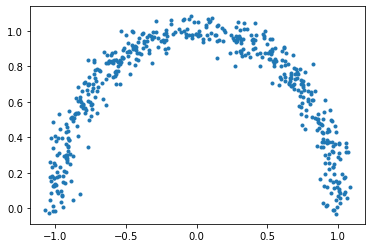

In [13]:
# Plot dataset points
import matplotlib.pyplot as plt

sampled = np.array([half_circle()[0].tolist() for i in range(500)])
plt.plot(sampled[:,0], sampled[:,1], '.')
plt.show()

In [22]:
# training
trainingdata = data.DataLoader(half_circle(n=1000), batch_size=64)

model = INN.Sequential(INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2),
                       INN.BatchNorm1d(2), INN.Nonlinear(2, 'RealNVP'), INN.JacobianLinear(2), INN.ResizeFeatures(2, 1))

model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prior distribution of output
p = INN.utilities.NormalDistribution()

loss_count = []
for i in range(50):
    losses = []
    for x in trainingdata:
        optimizer.zero_grad()
        y, logp, logdet = model(x)
        py = p.logp(y)

        loss = py + logp + logdet
        loss = -1 * loss.mean()

        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    loss_count.append(np.mean(losses))
    print(sum(losses) / len(losses))

1.223291765898466
1.013876285403967
0.8166838400065899
0.5403945222496986
0.2936104004038498
0.12893742800224572
0.0034339039120823145
-0.14217334473505616
-0.13985569239594042
-0.2074239469366148
-0.26068128552287817
-0.32526987325400114
-0.4844682030379772
-0.7474038563668728
-0.9248558059334755
-1.0802549049258232
-1.123768974095583
-1.1003035567700863
-1.1366827860474586
-1.1551992855966091
-1.3266329616308212
-1.2636653035879135
-1.249408297240734
-1.273848570883274
-1.264524094760418
-1.2570193856954575
-1.3229644000530243
-1.335098259150982
-1.301453672349453
-1.286019116640091
-1.315513715147972
-1.3339893147349358
-1.3400362133979797
-1.4075472429394722
-1.3716455325484276
-1.3572860583662987
-1.3293382152915
-1.358836717903614
-1.3634106293320656
-1.3925426453351974
-1.4606607407331467
-1.414954200387001
-1.343660444021225
-1.4281924962997437
-1.4228008389472961
-1.4096736088395119
-1.4132446348667145
-1.3642451092600822
-1.3689506873488426
-1.38292096555233


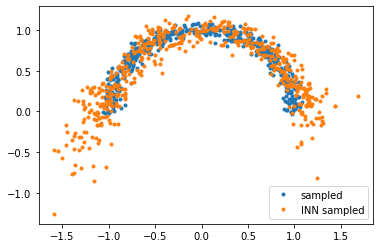

In [21]:
# plot training results
inn_sampled = model.inverse(torch.randn(500, 1)).detach()

plt.plot(sampled[:,0], sampled[:,1], '.', label='sampled')
plt.plot(inn_sampled[:,0], inn_sampled[:,1], '.', label='INN sampled')
plt.legend()
plt.show()

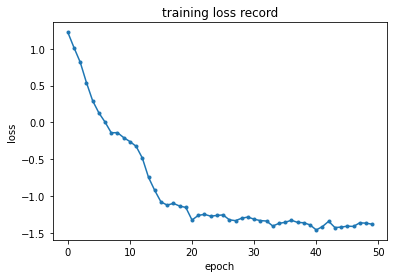

In [27]:
plt.plot(loss_count, '.-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss record')
plt.show()